# 2D Kernel with SPECFEM2D
By Andrea R.  
Utility functions written by Ridvan Orsvuran.  
Following file structure as in the Seisflows example (By Bryant Chow)

In [1]:
import os
import shutil
import matplotlib
import numpy as np
import FunctionsPlotBin
import matplotlib.pyplot as plt

from UtilityFunctions import read_trace, specfem2D_prep_save_forward, replace_line, save_trace, specfem2D_prep_adjoint, grid
from scipy.integrate import simps

# Domain: 
2D:   
x-dir = 4000 m   
z-dir = 4000 m   

### Source location
original x:    1000 m     
original z:    2000 m  

### Output station location: 
Station #1   AAS0001                             
original x:    3000 m  
original z:    2000 m  

### Boundary conditions 
Type: STACEY_ABSORBING_CONDITIONS  
absorbbottom                    = true  
absorbright                     = true  
absorbtop                       = true  
absorbleft                      = true  

### Velocity model:

#### Initial model:  
Model: P (or PI) velocity min,max =    3000 m/s              
Model: S velocity min,max         =    1800 m/s        
Model: density min,max            =    2700 kg/m3           

#### True model (~1% perturbation of the Vs - initial model):   
Model: P (or PI) velocity min,max =    3000 m/s                
Model: S velocity min,max         =    1820 m/s          
Model: density min,max            =    2700 kg/m3      

### Set Specfem2D and work directories 

In [2]:
specfem2d_path = "/Users/andreacamilarianoescandon/packages"
EXAMPLE = os.path.join(os.getcwd(),"Examples", "DATA_Example01")
WORKDIR = os.path.join(os.getcwd(),"work")

# Incase we've run this docs page before, delete the working directory before remaking
if os.path.exists(WORKDIR):
    shutil.rmtree(WORKDIR)

In [3]:
# Distribute the necessary file structure of the SPECFEM2D repository that we will reference
SPECFEM2D_ORIGINAL = os.path.join(specfem2d_path, "specfem2d") 
SPECFEM2D_BIN_ORIGINAL = os.path.join(SPECFEM2D_ORIGINAL, "bin")
SPECFEM2D_DATA_ORIGINAL = os.path.join(SPECFEM2D_ORIGINAL, "DATA")

# The SPECFEM2D working directory that we will create separate from the downloaded repo
SPECFEM2D_WORKDIR = os.path.join(WORKDIR, "ExampleKernel")
SPECFEM2D_BIN = os.path.join(SPECFEM2D_WORKDIR, "bin")
SPECFEM2D_DATA = os.path.join(SPECFEM2D_WORKDIR, "DATA")
SPECFEM2D_OUTPUT = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES")

# Pre-defined locations of velocity models we will generate using the solver
SPECFEM2D_MODEL_INIT = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES_INIT")
SPECFEM2D_MODEL_TRUE = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES_TRUE")

In [4]:
# Copy the binary files incase we update the source code. These can also be symlinked.
shutil.copytree(SPECFEM2D_BIN_ORIGINAL, SPECFEM2D_BIN)

# Copy the DATA/ directory
shutil.copytree(EXAMPLE, SPECFEM2D_DATA)
!pwd
!ls

/Users/andreacamilarianoescandon/FWI/JupyterNotebooks
A_InstallingSpecfem2d.ipynb           FunctionsPlotBin.py
B_Specfem2D_Example.ipynb             README.md
C_Specfem2D_Tomofile.ipynb            UtilityFunctions.py
D_Specfem2D_Kernel.ipynb              __pycache__
E_Specfem2D_ExampleLayeredModel.ipynb work
Examples


### Generate true model

In [5]:
os.chdir(SPECFEM2D_DATA)
specfem2D_prep_save_forward("Par_file")
# Modify the Par_file to increase Initial Vs by ~1% 
replace_line("Par_file",262,'1 1 2700.d0 3000.d0 1820.d0 0 0 9999 9999 0 0 0 0 0 0 \n')

In [6]:
# create the OUTPUT_FILES directory before running 
os.chdir(SPECFEM2D_WORKDIR)
if os.path.exists(SPECFEM2D_OUTPUT):
    shutil.rmtree(SPECFEM2D_OUTPUT)
os.mkdir(SPECFEM2D_OUTPUT)
!ls

DATA         OUTPUT_FILES bin


In [7]:
os.chdir(SPECFEM2D_WORKDIR)
!bin/xmeshfem2D > OUTPUT_FILES/mesher_log.txt
!bin/xspecfem2D > OUTPUT_FILES/solver_log.txt

# Move the model files (*.bin) into the OUTPUT_FILES directory
!mv DATA/*bin OUTPUT_FILES

# Make sure we don't overwrite this target model when creating our initial model in the next step
!mv OUTPUT_FILES OUTPUT_FILES_TRUE

!head OUTPUT_FILES_TRUE/solver_log.txt
!tail OUTPUT_FILES_TRUE/solver_log.txt


 **********************************************
 **** Specfem 2-D Solver - serial version  ****
 **********************************************

 Running Git version of the code corresponding to 
 dating From 


 NDIM =            2
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Test of SPECFEM2D with curved interfaces
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 02 - 03 - 2023                                 T i m e  : 09:44:31
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


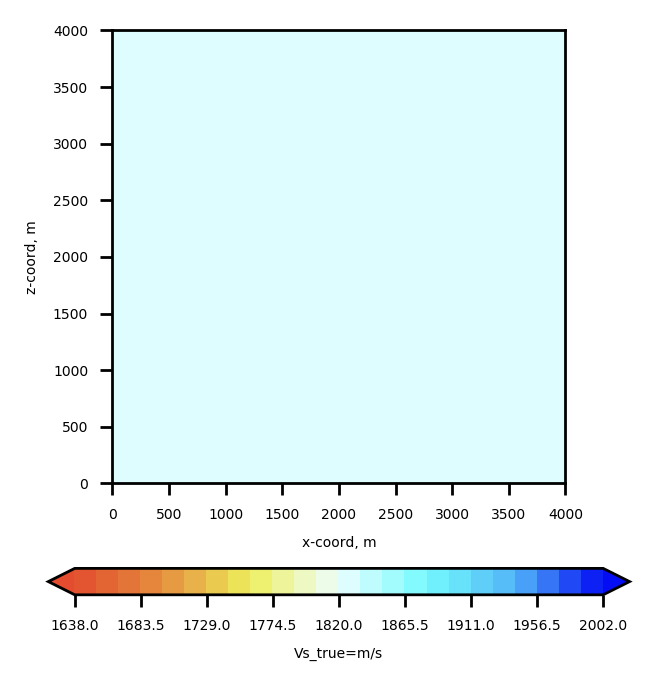

In [8]:
x_coords_file = 'OUTPUT_FILES_TRUE/proc000000_x.bin'
z_coords_file = 'OUTPUT_FILES_TRUE/proc000000_z.bin'
Vs_true       = 'OUTPUT_FILES_TRUE/proc000000_vs.bin'

# Plot 
FunctionsPlotBin.plotbin(x_coords_file,z_coords_file,Vs_true,SPECFEM2D_WORKDIR+'/Vs_true','Vs_true=m/s')

### Generate initial model

In [9]:
os.chdir(SPECFEM2D_DATA)
replace_line("Par_file",262,'1 1 2700.d0 3000.d0 1800.d0 0 0 9999 9999 0 0 0 0 0 0 \n')

In [10]:
# create the OUTPUT_FILES directory before running 
os.chdir(SPECFEM2D_WORKDIR)
if os.path.exists(SPECFEM2D_OUTPUT):
    shutil.rmtree(SPECFEM2D_OUTPUT)
os.mkdir(SPECFEM2D_OUTPUT)
!ls

DATA              OUTPUT_FILES_TRUE bin
OUTPUT_FILES      Vs_true.pdf


In [11]:
os.chdir(SPECFEM2D_WORKDIR)
!bin/xmeshfem2D > OUTPUT_FILES/mesher_log.txt
!bin/xspecfem2D > OUTPUT_FILES/solver_log.txt

# Move the model files (*.bin) into the OUTPUT_FILES directory
# The binary files of the velocity models are stored in DATA after running xspecfem2D
!mv DATA/*bin OUTPUT_FILES

# Store output files of initial model
!mv OUTPUT_FILES OUTPUT_FILES_INIT

!head OUTPUT_FILES_INIT/solver_log.txt
!tail OUTPUT_FILES_INIT/solver_log.txt


 **********************************************
 **** Specfem 2-D Solver - serial version  ****
 **********************************************

 Running Git version of the code corresponding to 
 dating From 


 NDIM =            2
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Test of SPECFEM2D with curved interfaces
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 02 - 03 - 2023                                 T i m e  : 09:44:41
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


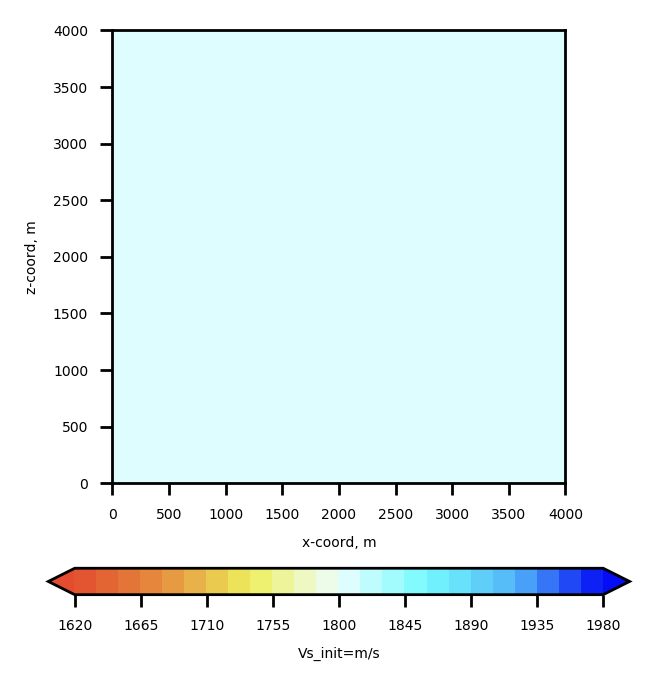

In [12]:
x_coords_file = 'OUTPUT_FILES_INIT/proc000000_x.bin'
z_coords_file = 'OUTPUT_FILES_INIT/proc000000_z.bin'
Vs_true       = 'OUTPUT_FILES_INIT/proc000000_vs.bin'

# Plot 
FunctionsPlotBin.plotbin(x_coords_file,z_coords_file,Vs_true,SPECFEM2D_WORKDIR+'/Vs_init','Vs_init=m/s')

### 3. Plot synthetic seismogram

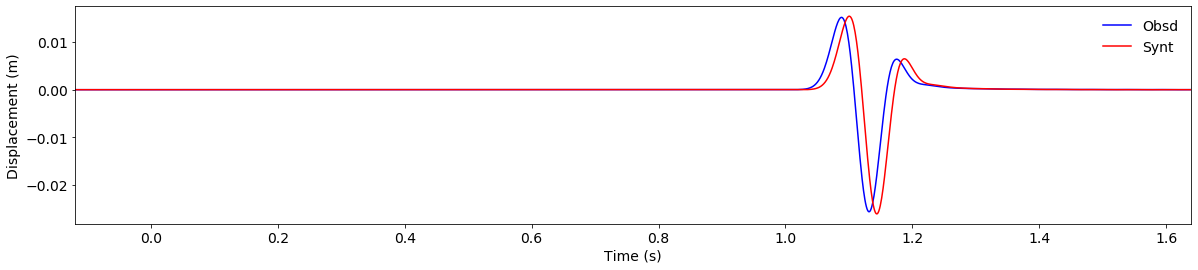

In [13]:
os.chdir(SPECFEM2D_WORKDIR)
# Read synthetic seismogram
obsd = read_trace(os.path.join("OUTPUT_FILES_TRUE","AA.S0001.BXY.semd"))
synt = read_trace(os.path.join("OUTPUT_FILES_INIT","AA.S0001.BXY.semd"))

# Process data
obsd.detrend("simple")
obsd.taper(0.05)
obsd.filter("bandpass", freqmin=0.01, freqmax=20)

synt.detrend("simple")
synt.taper(0.05)
synt.filter("bandpass", freqmin=0.01, freqmax=20)


matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(20, 4))
# Use the beginning time value from the file: tr.times()+tr.stats.b
ax.plot(obsd.times()+obsd.stats.b, obsd.data, "b", label="Obsd")
ax.plot(synt.times()+synt.stats.b, synt.data, "r", label="Synt")
ax.set_xlim(synt.stats.b, synt.times()[-1]+synt.stats.b)
ax.legend(frameon=False)
ax.set_xlabel("Time (s)");
ax.set_ylabel("Displacement (m)");
ax.tick_params(axis='both',which='major',labelsize=14)

### Misfit Calculation and Adjoint Source
For one seismogram, waveform misfit is

$$ \chi = \frac{1}{2} \int [d(t)-s(t)]^2 dt~, $$


and waveform adjoint source is

$$  f^\dagger (t) = s(t) - d(t)~,$$

where $s(t)$ is the synthetic, $d(t)$ is the observed seismograms.

In [14]:
# Misfit
misfit = simps((obsd.data-synt.data)**2, dx=obsd.stats.delta)
print(f"Misfit: {misfit:.6f}")

# Adjoint Source
adj = synt.copy()
adj.data = synt.data - obsd.data

# Process 
adj.detrend("simple")
adj.taper(0.05)
adj.filter("bandpass", freqmin=0.01, freqmax=20)

Misfit: 0.000012


AA.S0001..BXY | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:01.758900Z | 909.1 Hz, 1600 samples

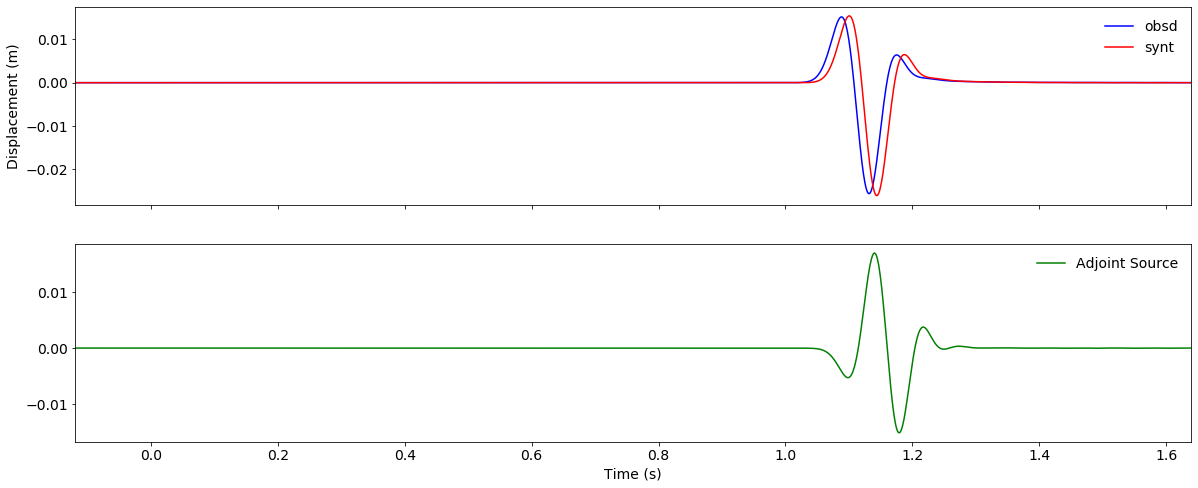

In [15]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(20, 8))
axes[0].plot(obsd.times()+obsd.stats.b, obsd.data, "b", label="obsd")
axes[0].plot(synt.times()+synt.stats.b, synt.data, "r", label="synt")
axes[0].set_xlim(obsd.stats.b, obsd.times()[-1]+obsd.stats.b)
axes[0].legend()
axes[0].legend(frameon=False)
axes[0].set_ylabel("Displacement (m)");

axes[1].plot(adj.times()+adj.stats.b, adj.data, "g", label="Adjoint Source")
axes[1].legend()
axes[1].legend(frameon=False)
axes[1].set_xlabel("Time (s)");
ax.tick_params(axis='both',which='major',labelsize=14)
matplotlib.rcParams.update({'font.size': 14})

### Adjoint simulation

In [16]:
os.chdir(SPECFEM2D_WORKDIR)
# Save adjoint source to SEM directory
os.makedirs("SEM", exist_ok=True)
save_trace(adj, "SEM/AA.S0001.BXY.adj")

For adjoint simulation, following `DATA/Par_file` needs be set

```toml
SIMULATION_TYPE                 = 3
# save the last frame, needed for adjoint simulation
SAVE_FORWARD                    = .false.
```

`specfem2D_prep_adjoint` function can be used for this purpose.

In [17]:
# Prepare Par_file
os.chdir(SPECFEM2D_DATA)
specfem2D_prep_adjoint("Par_file")

In [18]:
# create the OUTPUT_FILES directory before running and copy 
# results of OUTPUT_FILES_INIT to the new created OUTPUT_FILES, this is needed
# for the adjoint simulation because we saved the last frame in the 
# forward simulation of the initial model

os.chdir(SPECFEM2D_WORKDIR)
if os.path.exists(SPECFEM2D_OUTPUT):
    shutil.rmtree(SPECFEM2D_OUTPUT)
os.mkdir(SPECFEM2D_OUTPUT)
!cp OUTPUT_FILES_INIT/* OUTPUT_FILES
!ls


DATA              OUTPUT_FILES_INIT SEM               Vs_true.pdf
OUTPUT_FILES      OUTPUT_FILES_TRUE Vs_init.pdf       bin


In [19]:
os.chdir(SPECFEM2D_WORKDIR)
!bin/xmeshfem2D > OUTPUT_FILES/mesher_log.txt
!bin/xspecfem2D > OUTPUT_FILES/solver_log.txt

# Move the model files (*.bin) into the OUTPUT_FILES directory
# The binary files of the velocity models are stored in DATA after running xspecfem2D
!mv DATA/*bin OUTPUT_FILES

# Make sure we don't overwrite output files 
!mv OUTPUT_FILES OUTPUT_FILES_ADJ

!head OUTPUT_FILES_ADJ/solver_log.txt
!tail OUTPUT_FILES_ADJ/solver_log.txt


 **********************************************
 **** Specfem 2-D Solver - serial version  ****
 **********************************************

 Running Git version of the code corresponding to 
 dating From 


 NDIM =            2
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Test of SPECFEM2D with curved interfaces
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 02 - 03 - 2023                                 T i m e  : 09:45:04
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


### Plotting the Kernels

`./OUTPUT_FILES/proc000000_rhop_alpha_beta_kernel.dat` file holds the kernel data.

It is a text file contains 5 columns: `x`, `z`, `rhop`, `alpha`, `beta`.

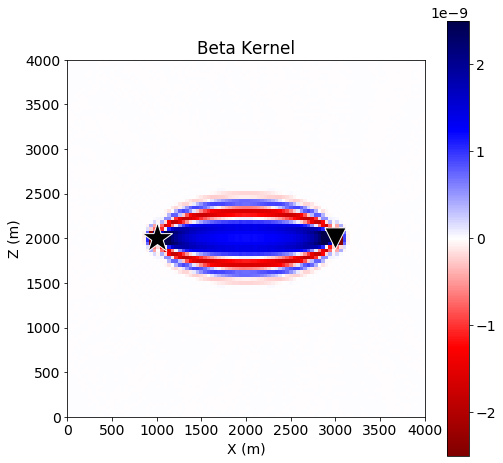

In [20]:
data = np.loadtxt("./OUTPUT_FILES_ADJ/proc000000_rhop_alpha_beta_kernel.dat")

# first column: x
x = data[:, 0]
# second column: z
z = data[:, 1]
# fifth column: beta_kernel
beta = data[:, 4]

# For plotting, you can check: specfem2D/utils/Visualization/plot_kernel.py
vmax = 2.5e-9
X, Z, BETA = grid(x, z, beta)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(BETA, vmax=vmax, vmin=-vmax, extent=[x.min(), x.max(), z.min(), z.max()],
               cmap="seismic_r")
ax.set_xlabel("X (m)")
ax.set_ylabel("Z (m)")
ax.set_title("Beta Kernel")

# Plot source and station
ax.scatter(1000, 2000, 1000, marker="*", color="black", edgecolor="white")
ax.scatter(3000, 2000, 450, marker="v", color="black", edgecolor="white")

plt.colorbar(im, ax=ax);
ax.tick_params(axis='both',which='major',labelsize=14)
matplotlib.rcParams.update({'font.size': 14})